In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cartpole


In [2]:
from matplotlib import pyplot as plt
from tqdm import tqdm

from varitop.integrator import DelIntegrator
from varitop.opti import Varitop

import casadi as cs
import numpy as np

In [3]:
steps = 200
t0 = 0
tf = 1
tspan = [t0, tf]
ts = np.linspace(t0, tf, steps)
dt = (tspan[1] - tspan[0]) / steps

q_0 = np.array([0, 0, 0, -1])
q_f = np.array([0, 0, 0, 1])

In [4]:
di = DelIntegrator(
    nq=4,
    nu=1,
)

In [5]:
q, v, u = di.q, di.dq, di.u

In [6]:
kinetic_energy = cs.Function("kinetic", [q, v], [0.5 * v.T @ v])
potential_energy = cs.Function("potential", [q, v], [9.81 * (q[3])])
total_energy = cs.Function(
    "total", [q, v], [kinetic_energy(q, v) + potential_energy(q, v)]
)
lagrangian = cs.Function("L", [q, v], [kinetic_energy(q, v) - potential_energy(q, v)])

In [7]:
di.lagrangian = lagrangian

In [8]:
di.add_constraint(q[1])
di.add_constraint((q[2] - q[0])**2 + (q[3] - q[1])**2 - 1)

In [9]:
di.add_force(cs.vcat([u[0], 0, 0, 0]))

In [10]:
vp = Varitop(
    integrator=di,
    nsteps=steps,
    dt=dt
)

In [11]:
vp.q.shape

(4, 201)

In [12]:
vp.subject_to(vp.q[:, 0] - vp.q[:, 1] == 0)
vp.subject_to(vp.q[:, -1] - vp.q[:, -2] == 0)

In [13]:
vp.set_initial_configuration(q_0)
vp.set_terminal_configuration(q_f)

In [14]:
vp.set_initial(vp.q, np.full((steps + 1, 4), q_0).T)
vp.set_initial(vp.u, np.full((steps, 1), 10000).T)

In [15]:
cost = vp.u @ vp.u.T
vp.set_cost(cost)

In [16]:
vp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5397
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2190

Total number of variables............................:     1404
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1210
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 3 (nx = 1404)
  #parameters: 0 (np = 0)
  #constraints: 203 (ng = 1210)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [17]:
vp.value(vp.q)

array([[-9.95950781e-15, -2.98035443e-14, -1.82037179e-03,
        -5.55970103e-03, -1.13125416e-02, -1.91686761e-02,
        -2.92119148e-02, -4.15183628e-02, -5.61541029e-02,
        -7.31722817e-02, -9.26096404e-02, -1.14482616e-01,
        -1.38783244e-01, -1.65475205e-01, -1.94490471e-01,
        -2.25727061e-01, -2.59048411e-01, -2.94284733e-01,
        -3.31236502e-01, -3.69679945e-01, -4.09374037e-01,
        -4.50068357e-01, -4.91510984e-01, -5.33455742e-01,
        -5.75668226e-01, -6.17930332e-01, -6.60043204e-01,
        -7.01828755e-01, -7.43129974e-01, -7.83810330e-01,
        -8.23752553e-01, -8.62857034e-01, -9.01040046e-01,
        -9.38231931e-01, -9.74375341e-01, -1.00942361e+00,
        -1.04333926e+00, -1.07609272e+00, -1.10766110e+00,
        -1.13802727e+00, -1.16717895e+00, -1.19510798e+00,
        -1.22180972e+00, -1.24728249e+00, -1.27152713e+00,
        -1.29454665e+00, -1.31634584e+00, -1.33693109e+00,
        -1.35631008e+00, -1.37449164e+00, -1.39148556e+0

In [18]:
qs_opt = vp.value(vp.q).T

In [19]:
qs_opt.shape

(201, 4)

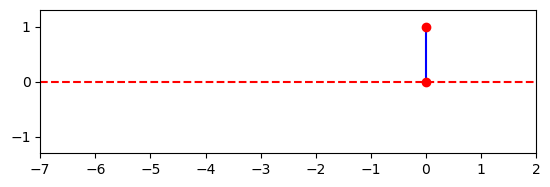

In [24]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots()

# Set the x and y limits of the plot
ax.set_xlim(-7, 2)
ax.set_ylim(-1.3, 1.3)
ax.set_aspect("equal")

# Create a line object for the line between the points
(line,) = ax.plot([], [], "b-")

# Create a scatter plot for the points
(points,) = ax.plot([], [], "ro")

# Create a horizontal line at qs_opt[1]
horizontal_line = ax.axhline(y=qs_opt[1, 1], color="r", linestyle="--")


# Animation update function
def update(frame):
    # Update the line and points data
    current = qs_opt[frame]
    line.set_data(current[[0, 2]], current[[1, 3]])
    points.set_data(current[[0, 2]], current[[1, 3]])
    # ax.set_xlim(-8, current[0] + 1.3)
    return line, points


# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs_opt), blit=True)

# Show the plot
animation.save("test.gif", writer="pillow")